# Netflix Streaming Analysis – Cleaned Version

This notebook:

1. Loads the raw CSV files into DuckDB.
2. Profiles missing values and duplicates for each table.
3. Cleans each table (removing/handling duplicates and missing values).
4. Re-runs exploratory data analysis (EDA) on the cleaned tables.

Adjust the `DATA_DIR` below if your CSV files are in a different folder on your machine.


In [59]:
%%capture
!pip -q install duckdb

In [60]:
import duckdb, os
import pandas as pd
import matplotlib.pyplot as plt

# Adjust this path if needed (Kaggle default below)
DATA_DIR = "/Users/nelmierandikudagodage/Downloads/DW/netflix"

con = duckdb.connect(database=':memory:')

# Load CSVs into DuckDB staging tables
con.execute(f"""
    CREATE TABLE users AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "users.csv")}');

    CREATE TABLE watch_history AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "watch_history.csv")}');

    CREATE TABLE movies AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "movies.csv")}');

    CREATE TABLE reviews AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "reviews.csv")}');

    CREATE TABLE recommendation_logs AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "recommendation_logs.csv")}');

    CREATE TABLE search_logs AS
    SELECT * FROM read_csv_auto('{os.path.join(DATA_DIR, "search_logs.csv")}');
""")

tables = [
    "users",
    "watch_history",
    "movies",
    "reviews",
    "recommendation_logs",
    "search_logs"
]

tables


['users',
 'watch_history',
 'movies',
 'reviews',
 'recommendation_logs',
 'search_logs']

In [61]:
for t in tables:
    print(f"\nPreview of {t}:")
    df_head = con.execute(f"SELECT * FROM {t} LIMIT 5").fetchdf()
    display(df_head)



Preview of users:


,user_id,email,first_name,last_name,age,gender,country,state_province,city,subscription_plan,subscription_start_date,is_active,monthly_spend,primary_device,household_size,created_at
0,user_00001,figueroajohn@example.org,Erica,Garza,43.0,Male,USA,Massachusetts,North Jefferyhaven,Basic,2024-04-08,True,36.06,Laptop,1.0,2023-04-01 14:40:50.540242
1,user_00002,blakeerik@example.com,Joshua,Bernard,38.0,Male,USA,Texas,North Noahstad,Premium+,2024-05-24,True,14.59,Desktop,2.0,2024-10-10 15:39:11.030515
2,user_00003,smiller@example.net,Barbara,Williams,32.0,Female,USA,Michigan,Traciebury,Standard,2023-09-22,False,11.71,Desktop,3.0,2024-06-29 14:27:49.560875
3,user_00004,mitchellclark@example.com,Chelsea,Ferguson,11.0,Male,USA,Ohio,South Noah,Standard,2024-08-21,True,28.56,Laptop,2.0,2023-04-11 01:01:59.614841
4,user_00005,richard13@example.net,Jason,Foster,21.0,Female,USA,Arizona,West Donald,Standard,2024-10-28,True,9.54,Desktop,6.0,2025-04-12 19:59:30.137806



Preview of watch_history:


,session_id,user_id,movie_id,watch_date,device_type,watch_duration_minutes,progress_percentage,action,quality,location_country,is_download,user_rating
0,session_000001,user_07271,movie_0511,2025-11-13,Tablet,63.9,34.6,completed,HD,USA,False,<NA>
1,session_000002,user_00861,movie_0588,2025-02-26,Laptop,120.1,44.2,started,HD,USA,False,<NA>
2,session_000003,user_05391,movie_0694,2024-12-15,Desktop,572.1,84.7,started,HD,Canada,False,1
3,session_000004,user_05192,movie_0234,2024-09-30,Desktop,395.3,89.9,completed,SD,USA,False,5
4,session_000005,user_05735,movie_0390,2024-08-04,Tablet,14.6,6.2,completed,HD,USA,False,<NA>



Preview of movies:


,movie_id,title,content_type,genre_primary,genre_secondary,release_year,duration_minutes,rating,language,country_of_origin,imdb_rating,production_budget,box_office_revenue,number_of_seasons,number_of_episodes,is_netflix_original,added_to_platform,content_warning
0,movie_0001,Dragon Legend,Stand-up Comedy,History,Thriller,2014,35.0,TV-Y,French,Japan,NaN,NaN,NaN,NaN,NaN,False,2023-08-07,False
1,movie_0002,Storm Warrior,Stand-up Comedy,Sci-Fi,None,2017,37.0,PG,Japanese,USA,3.3,NaN,NaN,NaN,NaN,False,2022-01-28,True
2,movie_0003,Fire Family,Movie,Drama,None,2003,142.0,TV-MA,English,USA,8.5,2114120.0,NaN,NaN,NaN,False,2021-05-04,True
3,movie_0004,Our Princess,Documentary,Sci-Fi,None,2011,131.0,NC-17,Japanese,USA,5.3,NaN,NaN,NaN,NaN,False,2022-11-26,False
4,movie_0005,Warrior Mission,Documentary,Sport,Mystery,2015,91.0,TV-G,English,USA,3.1,NaN,NaN,NaN,NaN,False,2023-06-15,False



Preview of reviews:


,review_id,user_id,movie_id,rating,review_date,device_type,is_verified_watch,helpful_votes,total_votes,review_text,sentiment,sentiment_score
0,review_000001,user_07066,movie_0360,4,2025-03-29,Mobile,False,3.0,5.0,Fantastic cinematography and plot twists.,positive,0.711
1,review_000002,user_02953,movie_0095,5,2024-07-19,Mobile,True,2.0,2.0,This series is a masterpiece!,positive,0.645
2,review_000003,user_05528,movie_0518,4,2025-02-11,Tablet,True,2.0,5.0,Fantastic cinematography and plot twists.,positive,0.730
3,review_000004,user_07612,movie_0672,5,2025-11-26,Mobile,True,7.0,7.0,One of the best series I've ever watched. High...,positive,0.798
4,review_000005,user_03424,movie_0580,3,2025-07-11,Mobile,True,1.0,5.0,Mixed feelings about this one.,neutral,0.410



Preview of recommendation_logs:


,recommendation_id,user_id,movie_id,recommendation_date,recommendation_type,recommendation_score,was_clicked,position_in_list,device_type,time_of_day,algorithm_version
0,rec_000001,user_06326,movie_0771,2025-07-03,new_releases,NaN,False,10,Tablet,evening,v1.4
1,rec_000002,user_02180,movie_0985,2024-11-07,genre_based,0.916,False,9,Mobile,evening,v1.4
2,rec_000003,user_03535,movie_0834,2024-08-22,personalized,0.816,False,2,Tablet,evening,v1.4
3,rec_000004,user_05025,movie_0718,2024-04-12,trending,0.771,False,16,Mobile,evening,v1.2
4,rec_000005,user_06794,movie_0718,2025-10-30,similar_users,0.251,False,9,Tablet,evening,v1.3



Preview of search_logs:


,search_id,user_id,search_query,search_date,results_returned,clicked_result_position,device_type,search_duration_seconds,had_typo,used_filters,location_country
0,search_000001,user_09864,classic movies,2024-03-22,20,2,Tablet,12.4,False,False,Canada
1,search_000002,user_08038,stand up comedy,2025-11-22,24,4,Tablet,63.5,True,False,USA
2,search_000003,user_02009,music documentaries,2024-10-09,86,1,Tablet,24.7,True,False,USA
3,search_000004,user_01083,comedy shows,2024-12-14,70,4,Mobile,53.7,False,False,USA
4,search_000005,user_04269,movies based on true stories,2025-01-10,48,<NA>,Tablet,69.6,True,False,USA


## Missing Values and Duplicate Checks (Raw Tables)

In [62]:
print("=== Total missing values per table (raw) ===")
for t in tables:
    df = con.execute(f"SELECT * FROM {t}").fetchdf()
    total_missing = int(df.isna().sum().sum())
    print(f"Missing values in {t}: {total_missing}")


=== Total missing values per table (raw) ===
Missing values in users: 4615
Missing values in watch_history: 104749
Missing values in movies: 3671
Missing values in reviews: 5624
Missing values in recommendation_logs: 7836
Missing values in search_logs: 14826


In [63]:
id_columns = {
    "users": "user_id",
    "watch_history": "session_id",
    "movies": "movie_id",
    "reviews": "review_id",
    "recommendation_logs": "recommendation_id",
    "search_logs": "search_id",
}

print("\n=== Duplicate checks by ID column (raw) ===")
for table, id_col in id_columns.items():
    total_rows, unique_ids = con.execute(f"""
        SELECT
            COUNT(*) AS total_rows,
            COUNT(DISTINCT {id_col}) AS unique_ids
        FROM {table}
    """).fetchone()
    duplicate_count = total_rows - unique_ids
    print(f"Duplicate {id_col} values in {table}: {duplicate_count}")



=== Duplicate checks by ID column (raw) ===
Duplicate user_id values in users: 300
Duplicate session_id values in watch_history: 5000
Duplicate movie_id values in movies: 40
Duplicate review_id values in reviews: 450
Duplicate recommendation_id values in recommendation_logs: 2000
Duplicate search_id values in search_logs: 1500


## Cleaning `users`

In [64]:
# 1) De-duplicate users on user_id (keep most recent subscription_start_date)
con.execute("""
CREATE OR REPLACE TABLE users_dedup AS
WITH ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY user_id
            ORDER BY subscription_start_date DESC NULLS LAST
        ) AS rn
    FROM users
    WHERE user_id IS NOT NULL
)
SELECT * EXCLUDE (rn)
FROM ranked
WHERE rn = 1;
""")

# 2) Impute missing values in users_dedup
con.execute("""
CREATE OR REPLACE TABLE users_clean AS
WITH medians AS (
    SELECT
        median(age) AS med_age,
        median(monthly_spend) AS med_spend
    FROM users_dedup
)
SELECT
    u.user_id,
    COALESCE(u.age, m.med_age) AS age,
    COALESCE(u.gender, 'Unknown') AS gender,
    COALESCE(u.country, 'Unknown') AS country,
    COALESCE(u.subscription_plan, 'Unknown') AS subscription_plan,
    u.subscription_start_date,
    COALESCE(u.is_active, FALSE) AS is_active,
    COALESCE(u.monthly_spend, m.med_spend) AS monthly_spend
FROM users_dedup u
CROSS JOIN medians m;
""")

users_clean = con.execute("SELECT * FROM users_clean").fetchdf()
users_clean.head()


,user_id,age,gender,country,subscription_plan,subscription_start_date,is_active,monthly_spend
0,user_00028,35.0,Male,USA,Standard,2024-09-14,True,41.44
1,user_00043,35.0,Male,Canada,Standard,2022-10-29,True,6.05
2,user_00066,35.0,Female,USA,Premium,2025-03-16,True,50.72
3,user_00067,38.0,Male,USA,Standard,2024-11-14,True,24.02
4,user_00089,32.0,Unknown,Canada,Standard,2023-05-29,True,13.56


## Cleaning `watch_history`

In [65]:
con.execute("""
CREATE OR REPLACE TABLE watch_history_clean AS
SELECT
    session_id,
    user_id,
    movie_id,
    watch_date,
    COALESCE(device_type, 'Unknown') AS device_type,
    COALESCE(watch_duration_minutes, 0) AS watch_duration_minutes,
    COALESCE(progress_percentage, 0) AS progress_percentage,
    COALESCE(action, 'Unknown') AS action,
    COALESCE(quality, 'Unknown') AS quality,
    COALESCE(location_country, 'Unknown') AS location_country,
    COALESCE(is_download, FALSE) AS is_download,
    user_rating
FROM (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY session_id
            ORDER BY watch_date DESC NULLS LAST
        ) AS rn
    FROM watch_history
)
WHERE rn = 1
  AND session_id IS NOT NULL
  AND user_id IS NOT NULL
  AND movie_id IS NOT NULL
  AND watch_date IS NOT NULL;
""")

watch_history_clean = con.execute("SELECT * FROM watch_history_clean").fetchdf()
watch_history_clean.head()


,session_id,user_id,movie_id,watch_date,device_type,watch_duration_minutes,progress_percentage,action,quality,location_country,is_download,user_rating
0,session_030582,user_00841,movie_0799,2025-04-04,Laptop,0.0,69.4,paused,4K,USA,True,<NA>
1,session_030607,user_02509,movie_0099,2025-08-06,Laptop,0.0,45.0,paused,4K,USA,False,<NA>
2,session_030633,user_08677,movie_0994,2024-03-30,Smart TV,113.9,33.4,stopped,HD,USA,False,<NA>
3,session_030670,user_08831,movie_0035,2025-05-08,Tablet,0.0,58.8,paused,4K,Canada,True,<NA>
4,session_030675,user_05971,movie_0615,2025-01-16,Tablet,0.0,0.0,completed,4K,USA,False,<NA>


## Cleaning `movies`

In [66]:
con.execute("""
CREATE OR REPLACE TABLE movies_dedup AS
WITH ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY movie_id
            ORDER BY added_to_platform DESC NULLS LAST
        ) AS rn
    FROM movies
    WHERE movie_id IS NOT NULL
)
SELECT * EXCLUDE (rn)
FROM ranked
WHERE rn = 1;
""")

con.execute("""
CREATE OR REPLACE TABLE movies_clean AS
WITH medians AS (
    SELECT
        median(duration_minutes) AS med_duration
    FROM movies_dedup
)
SELECT
    movie_id,
    COALESCE(title, 'Unknown') AS title,
    COALESCE(content_type, 'Unknown') AS content_type,
    COALESCE(genre_primary, 'Unknown') AS genre_primary,
    release_year,
    COALESCE(duration_minutes, med_duration) AS duration_minutes,
    COALESCE(rating, 'Unknown') AS rating,
    COALESCE(language, 'Unknown') AS language,
    imdb_rating,
    COALESCE(is_netflix_original, FALSE) AS is_netflix_original,
    added_to_platform
FROM movies_dedup
CROSS JOIN medians;
""")

movies_clean = con.execute("SELECT * FROM movies_clean").fetchdf()
movies_clean.head()


,movie_id,title,content_type,genre_primary,release_year,duration_minutes,rating,language,imdb_rating,is_netflix_original,added_to_platform
0,movie_0005,Warrior Mission,Documentary,Sport,2015,91.0,TV-G,English,3.1,False,2023-06-15
1,movie_0008,Old House,Movie,Horror,1991,109.0,TV-Y,Spanish,7.7,False,2020-10-04
2,movie_0036,House Legend,TV Series,Adventure,2018,61.0,PG-13,Spanish,6.5,False,2025-04-18
3,movie_0071,Phoenix Ice,TV Series,Music,2016,70.0,TV-MA,English,6.7,True,2024-06-17
4,movie_0090,Ice Kingdom,Documentary,Animation,2003,107.0,TV-PG,English,8.7,False,2021-12-24


## Cleaning `reviews`

In [67]:
con.execute("""
CREATE OR REPLACE TABLE reviews_dedup AS
WITH ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY review_id
            ORDER BY review_date DESC NULLS LAST
        ) AS rn
    FROM reviews
    WHERE review_id IS NOT NULL
)
SELECT * EXCLUDE (rn)
FROM ranked
WHERE rn = 1;
""")

con.execute("""
CREATE OR REPLACE TABLE reviews_clean AS
SELECT
    review_id,
    user_id,
    movie_id,
    rating,
    review_date,
    COALESCE(is_verified_watch, FALSE) AS is_verified_watch,
    COALESCE(helpful_votes, 0) AS helpful_votes,
    COALESCE(total_votes, 0) AS total_votes,
    COALESCE(review_text, '') AS review_text,
    COALESCE(sentiment, 'Unknown') AS sentiment,
    COALESCE(sentiment_score, 0) AS sentiment_score
FROM reviews_dedup
WHERE review_id IS NOT NULL
  AND user_id IS NOT NULL
  AND movie_id IS NOT NULL
  AND rating IS NOT NULL
  AND review_date IS NOT NULL;
""")

reviews_clean = con.execute("SELECT * FROM reviews_clean").fetchdf()
reviews_clean.head()


,review_id,user_id,movie_id,rating,review_date,is_verified_watch,helpful_votes,total_votes,review_text,sentiment,sentiment_score
0,review_000007,user_07818,movie_0081,2,2025-01-18,True,4.0,7.0,Not worth the time. Very predictable.,negative,0.106
1,review_000023,user_02227,movie_0695,5,2024-02-21,True,4.0,4.0,Outstanding direction and screenplay.,positive,0.980
2,review_000038,user_00615,movie_0069,2,2024-03-31,True,4.0,11.0,Not worth the time. Very predictable.,negative,0.149
3,review_000057,user_03748,movie_0947,2,2025-08-16,True,0.0,0.0,Not worth the time. Very predictable.,negative,0.134
4,review_000058,user_09368,movie_0151,4,2025-02-27,True,2.0,12.0,One of the best series I've ever watched. High...,positive,0.663


## Cleaning `recommendation_logs`

In [68]:
con.execute("""
CREATE OR REPLACE TABLE recommendation_logs_dedup AS
WITH ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY recommendation_id
            ORDER BY recommendation_date DESC NULLS LAST
        ) AS rn
    FROM recommendation_logs
    WHERE recommendation_id IS NOT NULL
)
SELECT * EXCLUDE (rn)
FROM ranked
WHERE rn = 1;
""")

con.execute("""
CREATE OR REPLACE TABLE recommendation_logs_clean AS
SELECT
    recommendation_id,
    user_id,
    movie_id,
    recommendation_date,
    COALESCE(recommendation_type, 'Unknown') AS recommendation_type,
    recommendation_score,
    COALESCE(was_clicked, FALSE) AS was_clicked,
    COALESCE(position_in_list, 0) AS position_in_list,
    COALESCE(device_type, 'Unknown') AS device_type,
    COALESCE(time_of_day, 'Unknown') AS time_of_day,
    COALESCE(algorithm_version, 'Unknown') AS algorithm_version
FROM recommendation_logs_dedup
WHERE recommendation_id IS NOT NULL
  AND user_id IS NOT NULL
  AND movie_id IS NOT NULL
  AND recommendation_date IS NOT NULL;
""")

recommendation_logs_clean = con.execute("SELECT * FROM recommendation_logs_clean").fetchdf()
recommendation_logs_clean.head()


,recommendation_id,user_id,movie_id,recommendation_date,recommendation_type,recommendation_score,was_clicked,position_in_list,device_type,time_of_day,algorithm_version
0,rec_000003,user_03535,movie_0834,2024-08-22,personalized,0.816,False,2,Tablet,evening,v1.4
1,rec_000005,user_06794,movie_0718,2025-10-30,similar_users,0.251,False,9,Tablet,evening,v1.3
2,rec_000011,user_00713,movie_0578,2025-09-19,personalized,0.496,False,3,Tablet,evening,Unknown
3,rec_000012,user_06987,movie_0779,2024-08-21,genre_based,0.231,False,19,Tablet,night,v1.3
4,rec_000013,user_04332,movie_0760,2025-03-19,trending,0.230,False,14,Mobile,evening,v1.4


## Cleaning `search_logs`

In [69]:
con.execute("""
CREATE OR REPLACE TABLE search_logs_dedup AS
WITH ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY search_id
            ORDER BY search_date DESC NULLS LAST
        ) AS rn
    FROM search_logs
    WHERE search_id IS NOT NULL
)
SELECT * EXCLUDE (rn)
FROM ranked
WHERE rn = 1;
""")

con.execute("""
CREATE OR REPLACE TABLE search_logs_clean AS
SELECT
    search_id,
    user_id,
    search_query,
    search_date,
    COALESCE(results_returned, 0) AS results_returned,
    COALESCE(clicked_result_position, 0) AS clicked_result_position,
    COALESCE(device_type, 'Unknown') AS device_type,
    COALESCE(search_duration_seconds, 0) AS search_duration_seconds,
    COALESCE(had_typo, FALSE) AS had_typo,
    COALESCE(used_filters, FALSE) AS used_filters,
    COALESCE(location_country, 'Unknown') AS location_country
FROM search_logs_dedup
WHERE search_id IS NOT NULL
  AND user_id IS NOT NULL
  AND search_date IS NOT NULL;
""")

search_logs_clean = con.execute("SELECT * FROM search_logs_clean").fetchdf()
search_logs_clean.head()


,search_id,user_id,search_query,search_date,results_returned,clicked_result_position,device_type,search_duration_seconds,had_typo,used_filters,location_country
0,search_000011,user_04781,biographies,2024-06-17,28,4,Tablet,0.0,False,False,USA
1,search_000057,user_02365,music documentaries,2024-05-12,79,0,Tablet,45.0,False,False,Canada
2,search_000077,user_01377,korean drama,2024-04-11,97,5,Smart TV,24.0,False,False,USA
3,search_000085,user_03666,halloween movies,2025-09-25,38,0,Laptop,17.4,False,False,USA
4,search_000086,user_05952,comedy shows,2024-05-21,90,0,Tablet,24.5,False,False,USA


## Quality Check After Cleaning

In [70]:
clean_tables = [
    "users_clean",
    "watch_history_clean",
    "movies_clean",
    "reviews_clean",
    "recommendation_logs_clean",
    "search_logs_clean"
]

print("=== Total missing values per table (cleaned) ===")
for t in clean_tables:
    df = con.execute(f"SELECT * FROM {t}").fetchdf()
    total_missing = int(df.isna().sum().sum())
    print(f"Missing values in {t}: {total_missing}")

print("\n=== Duplicate checks by ID column (cleaned) ===")
clean_id_columns = {
    "users_clean": "user_id",
    "watch_history_clean": "session_id",
    "movies_clean": "movie_id",
    "reviews_clean": "review_id",
    "recommendation_logs_clean": "recommendation_id",
    "search_logs_clean": "search_id",
}

for table, id_col in clean_id_columns.items():
    total_rows, unique_ids = con.execute(f"""
        SELECT
            COUNT(*) AS total_rows,
            COUNT(DISTINCT {id_col}) AS unique_ids
        FROM {table}
    """).fetchone()
    duplicate_count = total_rows - unique_ids
    print(f"Duplicate {id_col} values in {table}: {duplicate_count}")


=== Total missing values per table (cleaned) ===
Missing values in users_clean: 0
Missing values in watch_history_clean: 79886
Missing values in movies_clean: 144
Missing values in reviews_clean: 0
Missing values in recommendation_logs_clean: 5005
Missing values in search_logs_clean: 0

=== Duplicate checks by ID column (cleaned) ===
Duplicate user_id values in users_clean: 0
Duplicate session_id values in watch_history_clean: 0
Duplicate movie_id values in movies_clean: 0
Duplicate review_id values in reviews_clean: 0
Duplicate recommendation_id values in recommendation_logs_clean: 0
Duplicate search_id values in search_logs_clean: 0


## Exploratory Data Analysis (EDA) on Cleaned Tables

### Users – Demographics and Plans

           user_id           age  gender country subscription_plan  \
count        10000  10000.000000   10000   10000             10000   
unique       10000           NaN       5       2                 4   
top     user_00028           NaN  Female     USA          Standard   
freq             1           NaN    4203    6993              3522   
mean           NaN     35.029800     NaN     NaN               NaN   
min            NaN     -7.000000     NaN     NaN               NaN   
25%            NaN     28.000000     NaN     NaN               NaN   
50%            NaN     35.000000     NaN     NaN               NaN   
75%            NaN     42.000000     NaN     NaN               NaN   
max            NaN    109.000000     NaN     NaN               NaN   
std            NaN     11.791811     NaN     NaN               NaN   

           subscription_start_date is_active  monthly_spend  
count                        10000     10000   10000.000000  
unique                         NaN 

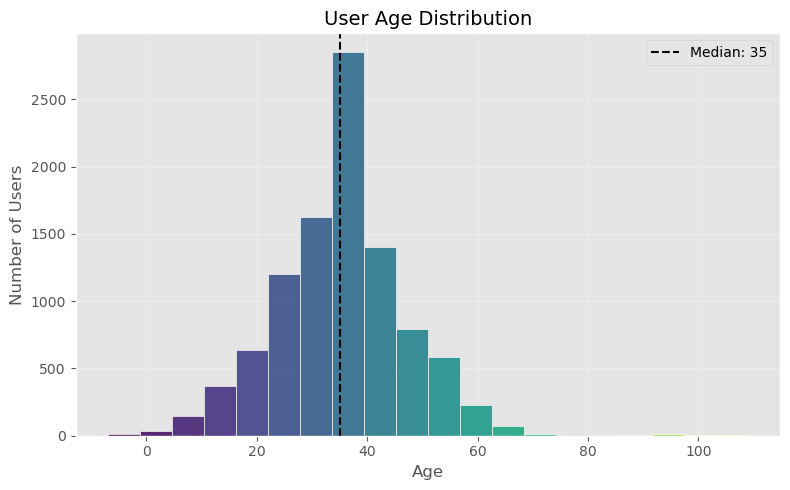

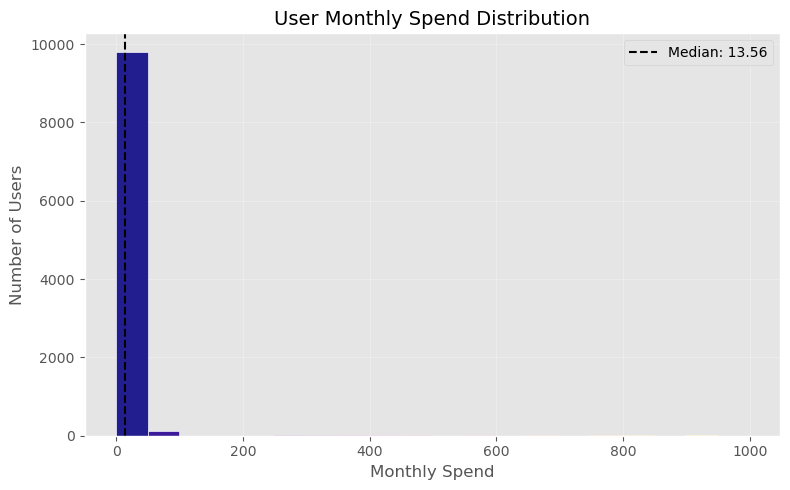

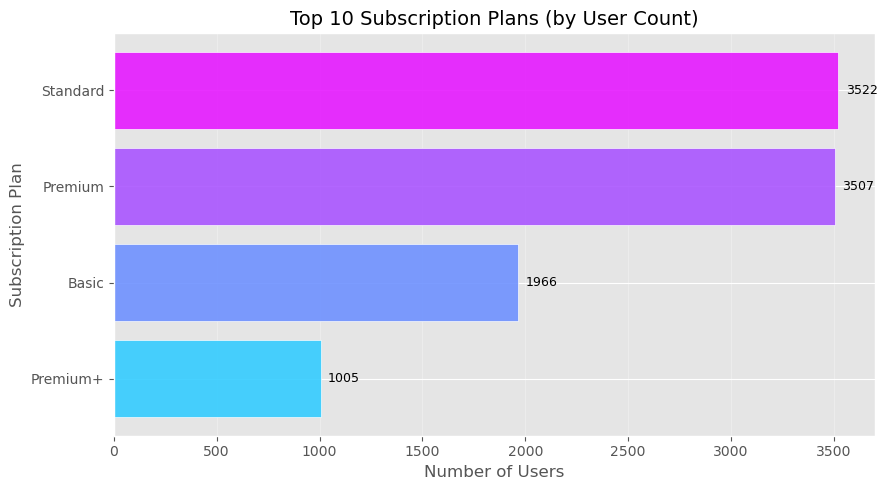

In [86]:
users_clean = con.execute("SELECT * FROM users_clean").fetchdf()

print(users_clean.describe(include="all"))

import numpy as np
import matplotlib.pyplot as plt

# Optional: global style
plt.style.use("ggplot")

# --- 1) Age distribution (with nicer styling + median line) ---
fig, ax = plt.subplots(figsize=(8, 5))
age_data = users_clean['age'].dropna()

n, bins, patches = ax.hist(
    age_data,
    bins=20,
    edgecolor="white",
    alpha=0.9
)

# Color bars with a colormap
cmap = plt.cm.viridis
for i, p in enumerate(patches):
    p.set_facecolor(cmap(i / len(patches)))

# Add median age line
median_age = age_data.median()
ax.axvline(median_age, color="black", linestyle="--", linewidth=1.5, label=f"Median: {median_age:.0f}")

ax.set_title("User Age Distribution", fontsize=14)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# --- 2) Monthly spend distribution (with annotations) ---
fig, ax = plt.subplots(figsize=(8, 5))
spend_data = users_clean['monthly_spend'].dropna()

n, bins, patches = ax.hist(
    spend_data,
    bins=20,
    edgecolor="white",
    alpha=0.9
)

cmap = plt.cm.plasma
for i, p in enumerate(patches):
    p.set_facecolor(cmap(i / len(patches)))

median_spend = spend_data.median()
ax.axvline(median_spend, color="black", linestyle="--", linewidth=1.5, label=f"Median: {median_spend:.2f}")

ax.set_title("User Monthly Spend Distribution", fontsize=14)
ax.set_xlabel("Monthly Spend", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# --- 3) Top subscription plans (horizontal bar chart + labels) ---
plan_counts = users_clean['subscription_plan'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(9, 5))

# Sort so the biggest bar appears at the top
plan_counts_sorted = plan_counts.sort_values()

y_pos = np.arange(len(plan_counts_sorted))
colors = plt.cm.cool(np.linspace(0.2, 0.9, len(plan_counts_sorted)))

ax.barh(y_pos, plan_counts_sorted.values, color=colors, edgecolor="white", alpha=0.9)
ax.set_yticks(y_pos)
ax.set_yticklabels(plan_counts_sorted.index)

ax.set_title("Top 10 Subscription Plans (by User Count)", fontsize=14)
ax.set_xlabel("Number of Users", fontsize=12)
ax.set_ylabel("Subscription Plan", fontsize=12)

# Add value labels at the end of each bar
for i, v in enumerate(plan_counts_sorted.values):
    ax.text(v + max(plan_counts_sorted.values)*0.01, i, str(v), va="center", fontsize=9)

ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()



### Watch History – Engagement

            session_id     user_id    movie_id                  watch_date  \
count           100000      100000      100000                      100000   
unique          100000       10000        1000                         NaN   
top     session_030582  user_06589  movie_0939                         NaN   
freq                 1          23         131                         NaN   
mean               NaN         NaN         NaN  2024-12-30 04:15:30.816000   
min                NaN         NaN         NaN         2024-01-01 00:00:00   
25%                NaN         NaN         NaN         2024-06-30 00:00:00   
50%                NaN         NaN         NaN         2024-12-29 00:00:00   
75%                NaN         NaN         NaN         2025-07-01 00:00:00   
max                NaN         NaN         NaN         2025-12-31 00:00:00   
std                NaN         NaN         NaN                         NaN   

       device_type  watch_duration_minutes  progress_percentage

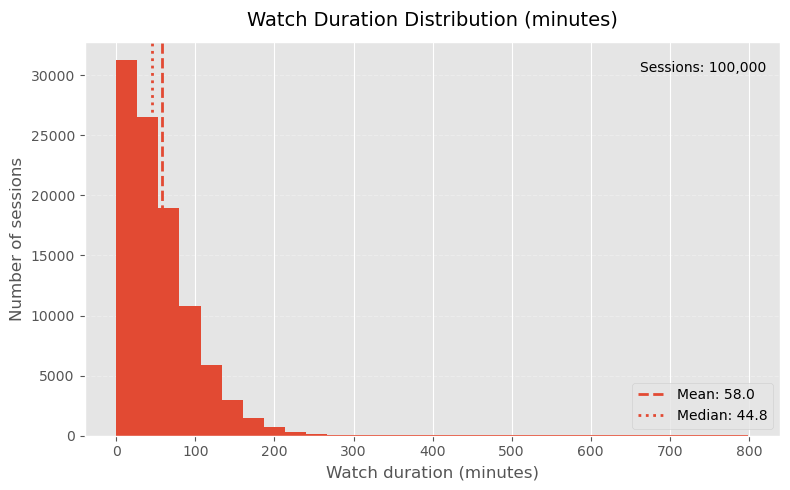

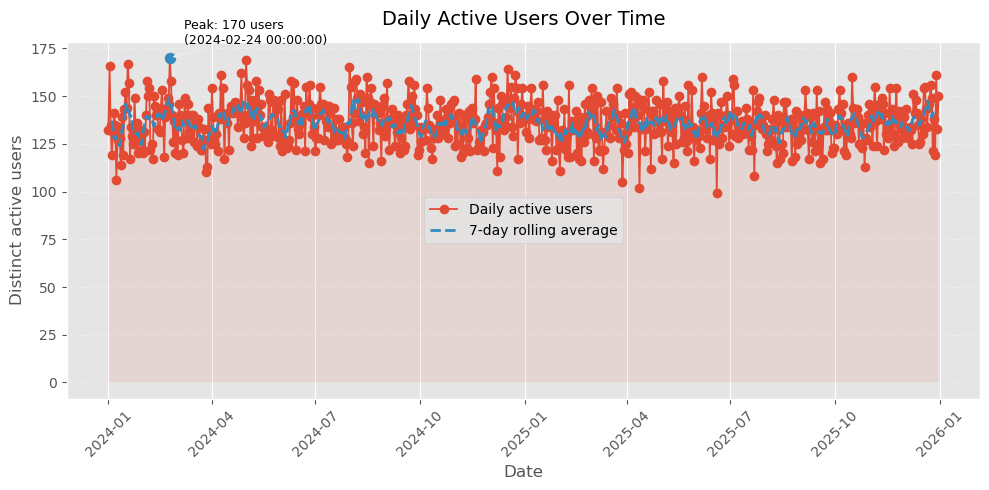

In [87]:
watch_history_clean = con.execute("SELECT * FROM watch_history_clean").fetchdf()

print(watch_history_clean.describe(include="all"))

import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Watch duration histogram
# ==========================

durations = watch_history_clean['watch_duration_minutes'].dropna()

fig, ax = plt.subplots(figsize=(8, 5))

# Histogram
n, bins, patches = ax.hist(durations, bins=30)

# Basic labels
ax.set_title("Watch Duration Distribution (minutes)", fontsize=14, pad=12)
ax.set_xlabel("Watch duration (minutes)")
ax.set_ylabel("Number of sessions")

# Grid + cleaner look
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Mean / median lines
mean_val = durations.mean()
median_val = durations.median()

ax.axvline(mean_val, linewidth=2, linestyle='--', label=f"Mean: {mean_val:.1f}")
ax.axvline(median_val, linewidth=2, linestyle=':', label=f"Median: {median_val:.1f}")

# Small annotation near the right side
ax.text(
    0.98, 0.95,
    f"Sessions: {len(durations):,}",
    transform=ax.transAxes,
    ha='right',
    va='top',
    fontsize=10,
)

ax.legend()
plt.tight_layout()
plt.show()

# ==========================
# 2. Daily active users over time
# ==========================

dau = con.execute("""
    SELECT
        watch_date::DATE AS d,
        COUNT(DISTINCT user_id) AS active_users
    FROM watch_history_clean
    GROUP BY d
    ORDER BY d
""").fetchdf()

# 7-day rolling average for smoother trend
dau['active_users_7d'] = dau['active_users'].rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize=(10, 5))

# Daily line
ax.plot(
    dau['d'],
    dau['active_users'],
    marker='o',
    linewidth=1.3,
    label='Daily active users'
)

# Smoothed line
ax.plot(
    dau['d'],
    dau['active_users_7d'],
    linewidth=2,
    linestyle='--',
    label='7-day rolling average'
)

# Light area under the daily line
ax.fill_between(
    dau['d'],
    dau['active_users'],
    alpha=0.1
)

# Highlight maximum DAU
max_idx = dau['active_users'].idxmax()
max_date = dau.loc[max_idx, 'd']
max_val = dau.loc[max_idx, 'active_users']

ax.scatter(max_date, max_val, s=60, zorder=3)
ax.annotate(
    f"Peak: {max_val} users\n({max_date})",
    xy=(max_date, max_val),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=9,
    arrowprops=dict(arrowstyle="->", linewidth=1)
)

ax.set_title("Daily Active Users Over Time", fontsize=14, pad=12)
ax.set_xlabel("Date")
ax.set_ylabel("Distinct active users")

ax.grid(True, axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


### Movies – Catalogue Overview

          movie_id        title content_type genre_primary  release_year  \
count         1000         1000         1000          1000   1000.000000   
unique        1000          673            5            20           NaN   
top     movie_0005  A Adventure        Movie     Adventure           NaN   
freq             1            6          444            68           NaN   
mean           NaN          NaN          NaN           NaN   2006.446000   
min            NaN          NaN          NaN           NaN   1953.000000   
25%            NaN          NaN          NaN           NaN   1998.000000   
50%            NaN          NaN          NaN           NaN   2006.000000   
75%            NaN          NaN          NaN           NaN   2016.000000   
max            NaN          NaN          NaN           NaN   2024.000000   
std            NaN          NaN          NaN           NaN     11.319506   

        duration_minutes rating language  imdb_rating is_netflix_original  \
count     

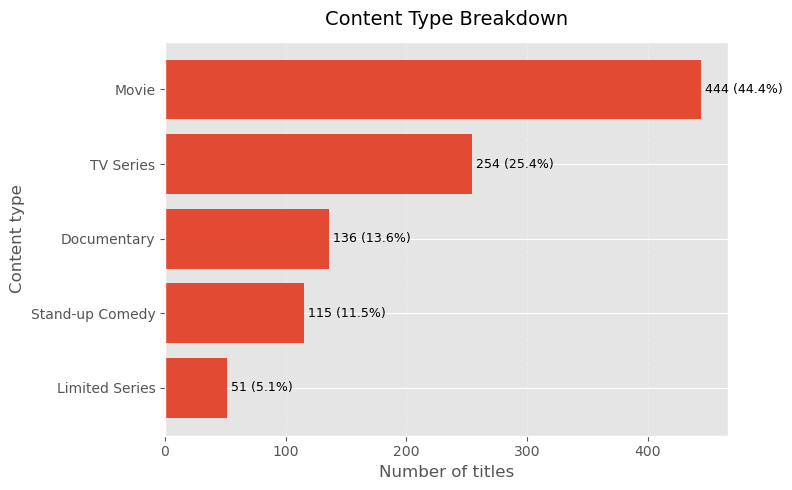

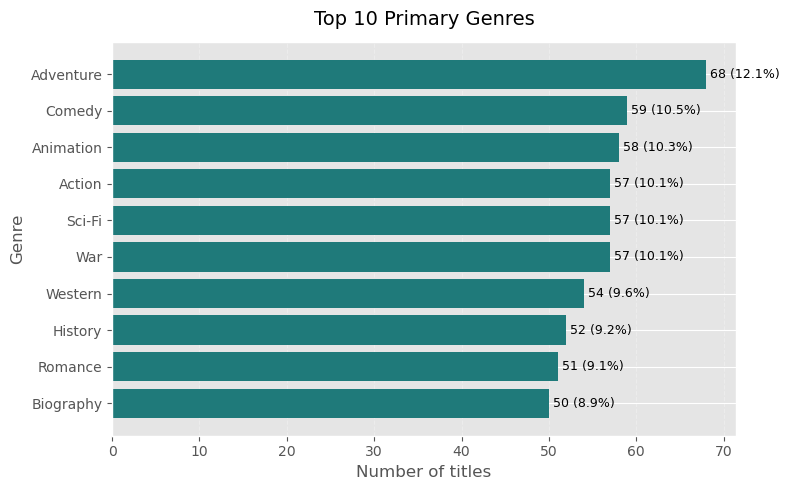

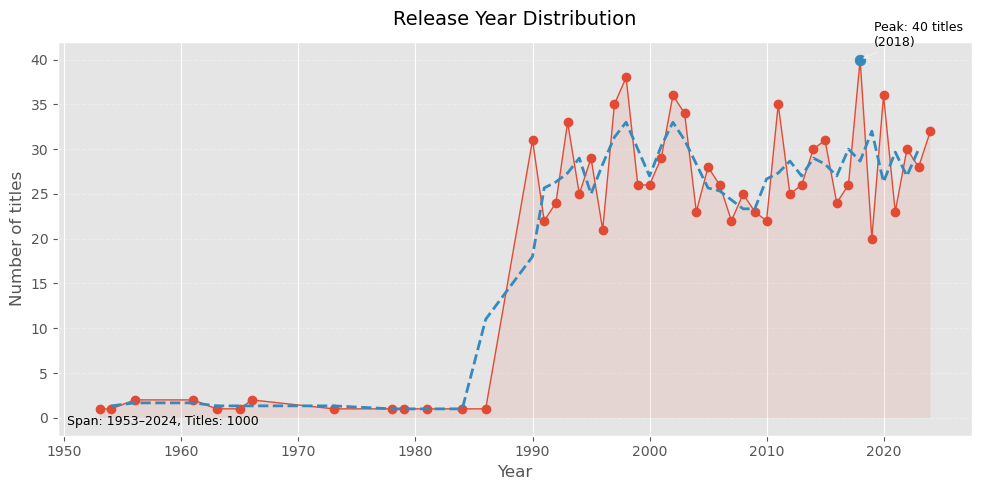

In [92]:
movies_clean = con.execute("SELECT * FROM movies_clean").fetchdf()

print(movies_clean.describe(include="all"))

import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Content type breakdown
# ==========================

content_counts = movies_clean['content_type'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))

# Sort smallest at bottom, largest at top
content_counts_sorted = content_counts.sort_values()

ax.barh(content_counts_sorted.index, content_counts_sorted.values)

ax.set_title("Content Type Breakdown", fontsize=14, pad=12)
ax.set_xlabel("Number of titles")
ax.set_ylabel("Content type")
ax.grid(True, axis='x', alpha=0.3, linestyle='--')

total_titles = content_counts_sorted.sum()

# Add labels at the end of each bar (count + %)
for i, (ct, val) in enumerate(content_counts_sorted.items()):
    pct = (val / total_titles) * 100
    ax.text(
        val,
        i,
        f" {val} ({pct:.1f}%)",
        va='center',
        ha='left',
        fontsize=9,
    )

plt.tight_layout()
plt.show()

# ==========================
# 2. Top 10 primary genres
# ==========================

genre_counts = movies_clean['genre_primary'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(8, 5))

genre_counts_sorted = genre_counts.sort_values()

PEACOCK_BLUE = "#1f7a7a"

ax.barh(genre_counts_sorted.index, genre_counts_sorted.values,color=PEACOCK_BLUE)

ax.set_title("Top 10 Primary Genres", fontsize=14, pad=12)
ax.set_xlabel("Number of titles")
ax.set_ylabel("Genre")
ax.grid(True, axis='x', alpha=0.3, linestyle='--')

top_total = genre_counts_sorted.sum()

for i, (g, val) in enumerate(genre_counts_sorted.items()):
    pct = (val / top_total) * 100
    ax.text(
        val,
        i,
        f" {val} ({pct:.1f}%)",
        va='center',
        ha='left',
        fontsize=9,
    )

plt.tight_layout()
plt.show()

# ==========================
# 3. Release year distribution (smoothed)
# ==========================

if 'release_year' in movies_clean.columns:
    years = movies_clean['release_year'].dropna().astype(int)

    if len(years) > 0:
        year_counts = years.value_counts().sort_index()

        # Optional: simple smoothing with rolling window
        window = 3 if len(year_counts) >= 3 else 1
        smoothed = year_counts.rolling(window=window, center=True).mean()

        fig, ax = plt.subplots(figsize=(10, 5))

        # Original yearly counts (thin line)
        ax.plot(
            year_counts.index,
            year_counts.values,
            linewidth=1.0,
            marker='o',
            label='Yearly count'
        )

        # Smoothed trend line (thicker, dashed)
        ax.plot(
            year_counts.index,
            smoothed.values,
            linewidth=2.0,
            linestyle='--',
            label=f'{window}-year rolling average'
        )

        # Fill for visual emphasis
        ax.fill_between(
            year_counts.index,
            year_counts.values,
            alpha=0.1
        )

        # Highlight peak year
        peak_year = year_counts.idxmax()
        peak_val = year_counts.max()
        ax.scatter(peak_year, peak_val, s=60, zorder=3)
        ax.annotate(
            f"Peak: {peak_val} titles\n({peak_year})",
            xy=(peak_year, peak_val),
            xytext=(10, 10),
            textcoords="offset points",
            fontsize=9,
            arrowprops=dict(arrowstyle="->", linewidth=1)
        )

        ax.set_title("Release Year Distribution", fontsize=14, pad=12)
        ax.set_xlabel("Year")
        ax.set_ylabel("Number of titles")
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        # Add small footer text with span
        span_text = f"Span: {int(years.min())}–{int(years.max())}, Titles: {len(years)}"
        ax.text(
            0.01,
            0.02,
            span_text,
            transform=ax.transAxes,
            ha='left',
            va='bottom',
            fontsize=9,
        )

        plt.tight_layout()
        plt.show()


### Reviews – Ratings and Sentiment

            review_id     user_id    movie_id        rating  \
count           15000       15000       15000  15000.000000   
unique          15000        7761        1000           NaN   
top     review_000007  user_09501  movie_0515           NaN   
freq                1           8          28           NaN   
mean              NaN         NaN         NaN      3.659400   
min               NaN         NaN         NaN      1.000000   
25%               NaN         NaN         NaN      3.000000   
50%               NaN         NaN         NaN      4.000000   
75%               NaN         NaN         NaN      5.000000   
max               NaN         NaN         NaN      5.000000   
std               NaN         NaN         NaN      1.110739   

                       review_date is_verified_watch  helpful_votes  \
count                        15000             15000   15000.000000   
unique                         NaN                 2            NaN   
top                           

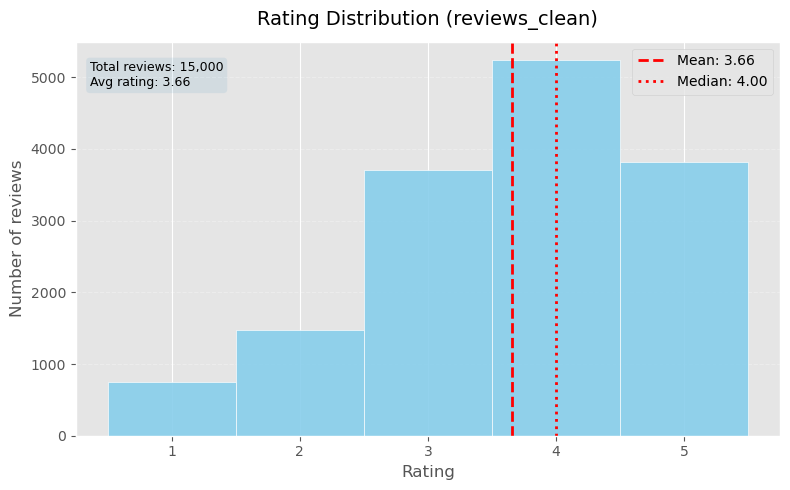

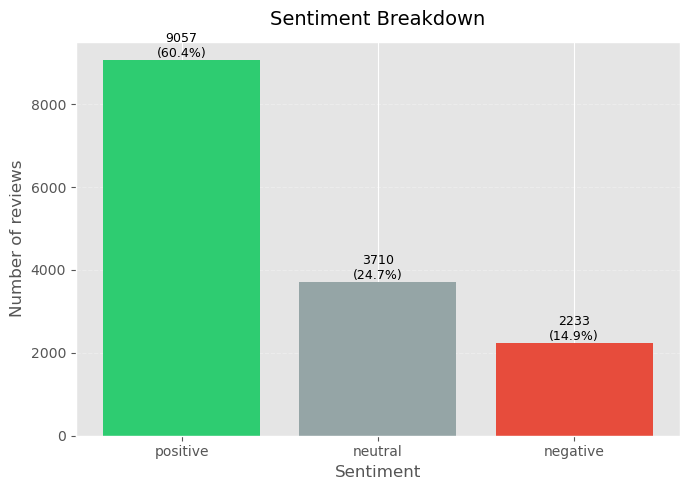

In [94]:
reviews_clean = con.execute("SELECT * FROM reviews_clean").fetchdf()

print(reviews_clean.describe(include="all"))

import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Rating distribution
# ==========================
ratings = reviews_clean['rating'].dropna()

fig, ax = plt.subplots(figsize=(8, 5))

# Treat ratings as discrete buckets (e.g. 1–5 or 1–10)
unique_ratings = np.sort(ratings.unique())
bins = np.arange(unique_ratings.min() - 0.5, unique_ratings.max() + 1.5, 1)

# Sky-blue bars
counts, _, _ = ax.hist(
    ratings,
    bins=bins,
    edgecolor="white",
    alpha=0.9,
    color="#87CEEB"      # sky blue
)

ax.set_title("Rating Distribution (reviews_clean)", fontsize=14, pad=12)
ax.set_xlabel("Rating")
ax.set_ylabel("Number of reviews")
ax.set_xticks(unique_ratings)
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Mean / median lines
mean_val = ratings.mean()
median_val = ratings.median()

# Mean & median in red
ax.axvline(mean_val, linestyle='--', linewidth=2,
           color="red", label=f"Mean: {mean_val:.2f}")
ax.axvline(median_val, linestyle=':', linewidth=2,
           color="red", label=f"Median: {median_val:.2f}")

# Add total reviews and average as a small info box
ax.text(
    0.02, 0.95,
    f"Total reviews: {len(ratings):,}\nAvg rating: {mean_val:.2f}",
    transform=ax.transAxes,
    fontsize=9,
    va='top',
    ha='left',
    bbox=dict(boxstyle="round,pad=0.3", alpha=0.1)
)

ax.legend()
plt.tight_layout()
plt.show()

# ==========================
# 2. Sentiment breakdown
# ==========================
sentiment_counts = reviews_clean['sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))

# Define a colorful palette for common sentiment labels
palette = {
    "positive": "#2ecc71",  # green
    "negative": "#e74c3c",  # red
    "neutral":  "#95a5a6",  # grey
}
colors = [palette.get(s, "#3498db") for s in sentiment_counts.index]

bars = ax.bar(
    sentiment_counts.index,
    sentiment_counts.values,
    color=colors
)

ax.set_title("Sentiment Breakdown", fontsize=14, pad=12)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number of reviews")
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

total = sentiment_counts.sum()

# Add count + percentage labels above each bar
for bar, label in zip(bars, sentiment_counts.index):
    height = bar.get_height()
    pct = height / total * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Recommendation Logs – Click-through

       recommendation_id     user_id    movie_id         recommendation_date  \
count              50000       50000       50000                       50000   
unique             50000        9921        1000                         NaN   
top           rec_000003  user_00231  movie_0946                         NaN   
freq                   1          17          84                         NaN   
mean                 NaN         NaN         NaN  2025-01-01 00:46:13.440000   
min                  NaN         NaN         NaN         2024-01-01 00:00:00   
25%                  NaN         NaN         NaN         2024-07-02 00:00:00   
50%                  NaN         NaN         NaN         2025-01-01 00:00:00   
75%                  NaN         NaN         NaN         2025-07-04 00:00:00   
max                  NaN         NaN         NaN         2025-12-31 00:00:00   
std                  NaN         NaN         NaN                         NaN   

       recommendation_type  recommendat

,recommendation_type,ctr
0,new_releases,0.155678
1,trending,0.151473
2,similar_users,0.150976
3,personalized,0.149066
4,genre_based,0.147863


/var/folders/mt/1mrrpw8525zgl5hv04pnp60w0000gn/T/ipykernel_91816/155093954.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


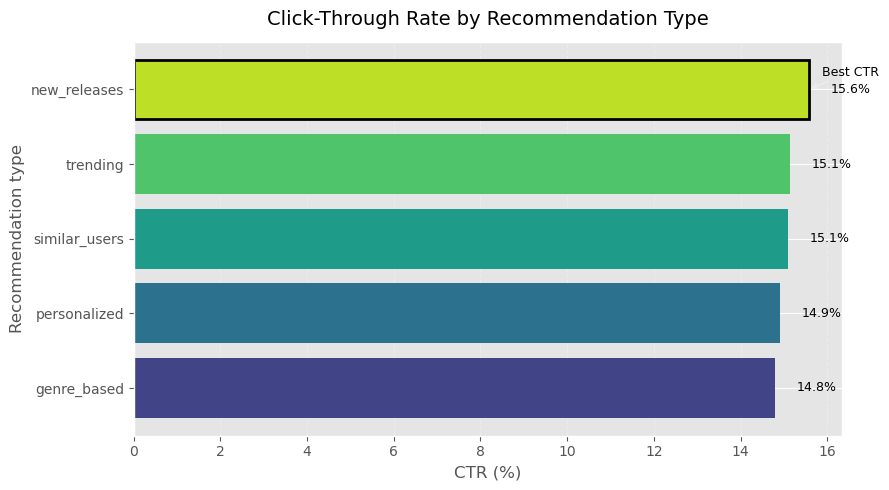

In [95]:
recommendation_logs_clean = con.execute(
    "SELECT * FROM recommendation_logs_clean"
).fetchdf()

print(recommendation_logs_clean.describe(include="all"))

# Simple click-through rate (CTR)
ctr_df = con.execute("""
    SELECT
        recommendation_type,
        AVG(CASE WHEN was_clicked THEN 1.0 ELSE 0.0 END) AS ctr
    FROM recommendation_logs_clean
    GROUP BY recommendation_type
    ORDER BY ctr DESC
""").fetchdf()

display(ctr_df)

import numpy as np
import matplotlib.pyplot as plt

# Convert to percentage for nicer reading
ctr_df["ctr_pct"] = ctr_df["ctr"] * 100
ctr_sorted = ctr_df.sort_values("ctr_pct", ascending=True)

fig, ax = plt.subplots(figsize=(9, 5))

# Advanced gradient colors using a colormap
cmap = plt.cm.get_cmap("viridis")
colors = cmap(np.linspace(0.2, 0.9, len(ctr_sorted)))

bars = ax.barh(
    ctr_sorted["recommendation_type"],
    ctr_sorted["ctr_pct"],
    color=colors
)

ax.set_title("Click-Through Rate by Recommendation Type", fontsize=14, pad=12)
ax.set_xlabel("CTR (%)")
ax.set_ylabel("Recommendation type")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Label each bar with value
for bar, val in zip(bars, ctr_sorted["ctr_pct"]):
    ax.text(
        val + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.1f}%",
        va="center",
        fontsize=9,
    )

# Highlight best performer (thicker border)
best_idx = np.argmax(ctr_sorted["ctr_pct"].values)
best_bar = bars[best_idx]
best_val = ctr_sorted.iloc[best_idx]["ctr_pct"]
best_y = best_bar.get_y() + best_bar.get_height() / 2

best_bar.set_edgecolor("black")
best_bar.set_linewidth(2)

ax.annotate(
    "Best CTR",
    xy=(best_val, best_y),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=9,
    arrowprops=dict(arrowstyle="->", linewidth=1),
)

plt.tight_layout()
plt.show()


### Search Logs – Behaviour

            search_id     user_id     search_query  \
count           25000       25000            25000   
unique          25000        9186               32   
top     search_000011  user_05805  stand up comedy   
freq                1           9              958   
mean              NaN         NaN              NaN   
min               NaN         NaN              NaN   
25%               NaN         NaN              NaN   
50%               NaN         NaN              NaN   
75%               NaN         NaN              NaN   
max               NaN         NaN              NaN   
std               NaN         NaN              NaN   

                       search_date  results_returned  clicked_result_position  \
count                        25000      25000.000000             25000.000000   
unique                         NaN               NaN                      NaN   
top                            NaN               NaN                      NaN   
freq                       

/var/folders/mt/1mrrpw8525zgl5hv04pnp60w0000gn/T/ipykernel_91816/4193688183.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("plasma")


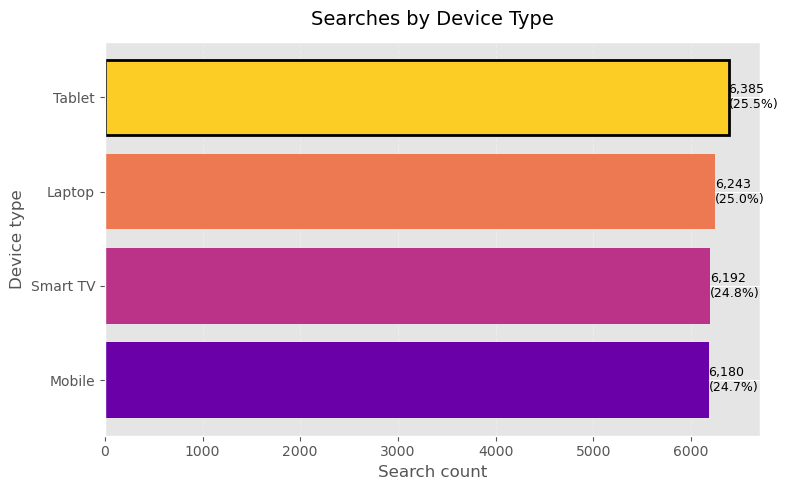

,had_typo,cnt
0,False,21227
1,True,3773


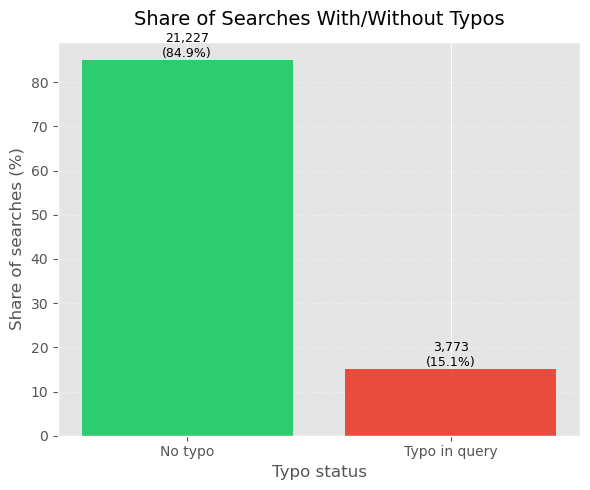

In [96]:
search_logs_clean = con.execute("SELECT * FROM search_logs_clean").fetchdf()

print(search_logs_clean.describe(include="all"))

import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1. Searches by device type
# ==========================
device_counts = search_logs_clean['device_type'].value_counts()
device_counts_sorted = device_counts.sort_values()

fig, ax = plt.subplots(figsize=(8, 5))

# Gradient colors from a nice colormap (no default blue)
cmap = plt.cm.get_cmap("plasma")
colors = cmap(np.linspace(0.2, 0.9, len(device_counts_sorted)))

bars = ax.barh(
    device_counts_sorted.index,
    device_counts_sorted.values,
    color=colors
)

ax.set_title("Searches by Device Type", fontsize=14, pad=12)
ax.set_xlabel("Search count")
ax.set_ylabel("Device type")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

total_searches = device_counts_sorted.sum()

# Add labels with count + %
for bar, val in zip(bars, device_counts_sorted.values):
    pct = val / total_searches * 100
    ax.text(
        val + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{int(val):,}\n({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
    )

# Highlight the most used device
best_idx = np.argmax(device_counts_sorted.values)
best_bar = bars[best_idx]
best_bar.set_edgecolor("black")
best_bar.set_linewidth(2)

plt.tight_layout()
plt.show()

# ==========================
# 2. Typo rate summary
# ==========================
typo_rate_df = con.execute("""
    SELECT
        had_typo,
        COUNT(*) AS cnt
    FROM search_logs_clean
    GROUP BY had_typo
""").fetchdf()

display(typo_rate_df)

# Prepare labels & percentages
# Handle bool/0/1 robustly
labels = typo_rate_df['had_typo'].astype(str)
labels = labels.replace({"True": "Typo in query", "False": "No typo",
                         "1": "Typo in query", "0": "No typo"})

typo_rate_df['label'] = labels
typo_rate_df['pct'] = typo_rate_df['cnt'] / typo_rate_df['cnt'].sum() * 100

fig, ax = plt.subplots(figsize=(6, 5))

# Advanced custom colors: green for no typo, red for typo
color_map = {
    "No typo": "#2ecc71",
    "Typo in query": "#e74c3c",
}
colors = [color_map.get(lbl, "#3498db") for lbl in typo_rate_df['label']]

bars = ax.bar(
    typo_rate_df['label'],
    typo_rate_df['pct'],
    color=colors
)

ax.set_title("Share of Searches With/Without Typos", fontsize=14, pad=12)
ax.set_ylabel("Share of searches (%)")
ax.set_xlabel("Typo status")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)

# Label each bar with count + %
for bar, (_, row) in zip(bars, typo_rate_df.iterrows()):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(row['cnt']):,}\n({row['pct']:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


## Summary

- Raw CSVs were loaded into DuckDB staging tables.
- Missing values and duplicates were profiled for each table.
- Cleaned tables (`*_clean`) were created with:
  - De-duplication based on primary ID columns.
  - Dropping rows with missing keys (IDs and critical dates).
  - Imputation or default values for non-key attributes.
- EDA was re-run on the cleaned tables to understand users, content, engagement, reviews, recommendations, and search behaviour.


# Merge Data

In [77]:
# Ensure the core merged view exists
con.execute("""
CREATE OR REPLACE VIEW vw_user_movie_sessions AS
SELECT
    w.session_id,
    w.user_id,
    w.movie_id,
    w.watch_date,
    w.watch_duration_minutes,
    w.progress_percentage,
    w.device_type         AS watch_device,
    w.location_country    AS watch_country,
    w.is_download,
    w.user_rating,
    -- user attributes
    u.age,
    u.gender,
    u.country             AS user_country,
    u.subscription_plan,
    u.monthly_spend,
    u.is_active,
    -- movie attributes
    m.title,
    m.content_type,
    m.genre_primary,
    m.release_year,
    m.duration_minutes    AS movie_duration_minutes,
    m.rating              AS content_rating,
    m.language,
    m.imdb_rating,
    m.is_netflix_original
FROM watch_history_clean w
LEFT JOIN users_clean  u USING (user_id)
LEFT JOIN movies_clean m USING (movie_id);
""")


### Create a merged sessions view (users + movies + watch_history)

A very useful starting point: one big view that combines sessions + user + movie info.

In [78]:
# Core merged view: one row per watch session with user + movie attributes
con.execute("""
CREATE OR REPLACE VIEW vw_user_movie_sessions AS
SELECT
    w.session_id,
    w.user_id,
    w.movie_id,
    w.watch_date,
    w.watch_duration_minutes,
    w.progress_percentage,
    w.device_type         AS watch_device,
    w.location_country    AS watch_country,
    w.is_download,
    w.user_rating,
    -- user attributes
    u.age,
    u.gender,
    u.country             AS user_country,
    u.subscription_plan,
    u.monthly_spend,
    u.is_active,
    -- movie attributes
    m.title,
    m.content_type,
    m.genre_primary,
    m.release_year,
    m.duration_minutes    AS movie_duration_minutes,
    m.rating              AS content_rating,
    m.language,
    m.imdb_rating,
    m.is_netflix_original
FROM watch_history_clean w
LEFT JOIN users_clean  u USING (user_id)
LEFT JOIN movies_clean m USING (movie_id);
""")

# Quick check
con.execute("SELECT * FROM vw_user_movie_sessions LIMIT 5").fetchdf()


,session_id,user_id,movie_id,watch_date,watch_duration_minutes,progress_percentage,watch_device,watch_country,is_download,user_rating,...,is_active,title,content_type,genre_primary,release_year,movie_duration_minutes,content_rating,language,imdb_rating,is_netflix_original
0,session_030582,user_00841,movie_0799,2025-04-04,0.0,69.4,Laptop,USA,True,<NA>,...,True,Fire Secret,TV Series,Crime,1992,39.0,TV-PG,English,8.3,True
1,session_030607,user_02509,movie_0099,2025-08-06,0.0,45.0,Laptop,USA,False,<NA>,...,True,Dragon Day,Documentary,Western,2021,110.0,PG,English,8.3,False
2,session_030633,user_08677,movie_0994,2024-03-30,113.9,33.4,Smart TV,USA,False,<NA>,...,True,Battle Queen,Movie,Mystery,1990,119.0,TV-14,German,1.4,False
3,session_030670,user_08831,movie_0035,2025-05-08,0.0,58.8,Tablet,Canada,True,<NA>,...,True,Princess Love,TV Series,Family,1994,38.0,TV-PG,English,7.4,False
4,session_030675,user_05971,movie_0615,2025-01-16,0.0,0.0,Tablet,USA,False,<NA>,...,True,An Fire,Movie,Crime,2016,136.0,PG,English,5.1,True


### Insight: Average watch duration & progress by subscription plan

,subscription_plan,sessions,avg_watch_minutes,avg_progress
0,Basic,19755,58.486560,46.026748
1,Premium+,9947,58.293425,46.235136
2,Standard,35305,57.947347,46.100414
3,Premium,34993,57.601938,45.597691


/var/folders/mt/1mrrpw8525zgl5hv04pnp60w0000gn/T/ipykernel_91816/297131394.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


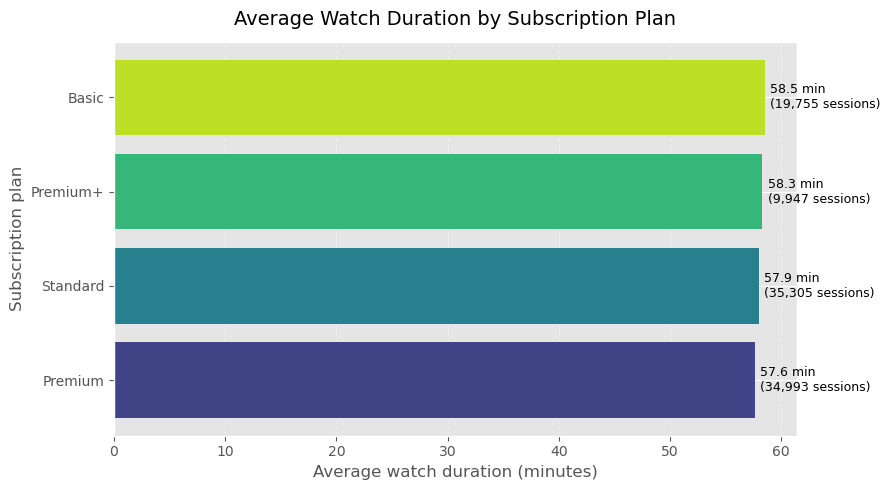

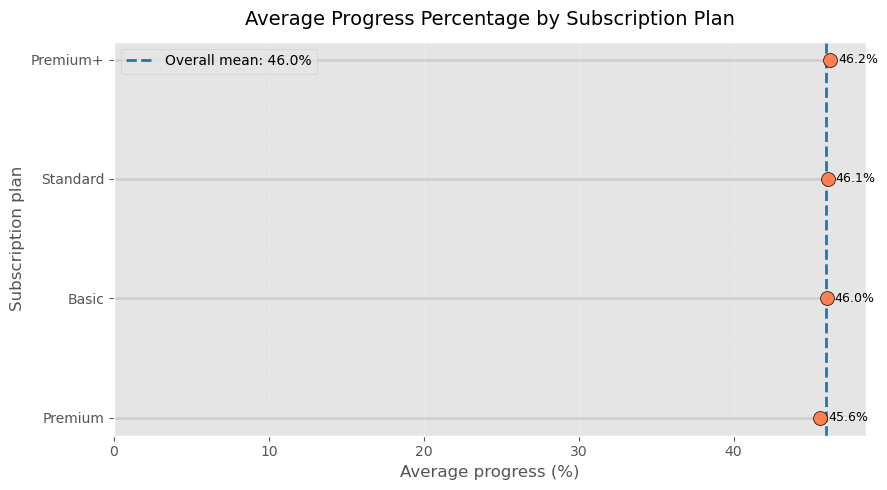

In [97]:
import numpy as np
import matplotlib.pyplot as plt

sql_avg_watch_by_plan = """
SELECT
    subscription_plan,
    COUNT(*) AS sessions,
    AVG(watch_duration_minutes) AS avg_watch_minutes,
    AVG(progress_percentage)    AS avg_progress
FROM vw_user_movie_sessions
GROUP BY subscription_plan
ORDER BY avg_watch_minutes DESC;
"""

df_avg_watch_by_plan = con.execute(sql_avg_watch_by_plan).fetchdf()
display(df_avg_watch_by_plan)

# -------------------------------------------------
# 1) Average watch duration – gradient barh + labels
# -------------------------------------------------
df_watch = df_avg_watch_by_plan.sort_values("avg_watch_minutes")

fig, ax = plt.subplots(figsize=(9, 5))

# Gradient colors from a colormap
cmap = plt.cm.get_cmap("viridis")
colors = cmap(np.linspace(0.2, 0.9, len(df_watch)))

bars = ax.barh(
    df_watch["subscription_plan"],
    df_watch["avg_watch_minutes"],
    color=colors
)

ax.set_title("Average Watch Duration by Subscription Plan", fontsize=14, pad=12)
ax.set_xlabel("Average watch duration (minutes)")
ax.set_ylabel("Subscription plan")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Label each bar with value + sessions
for bar, (_, row) in zip(bars, df_watch.iterrows()):
    duration = row["avg_watch_minutes"]
    sessions = row["sessions"]
    ax.text(
        duration + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{duration:.1f} min\n({sessions:,} sessions)",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 2) Average progress – lollipop chart with mean line
# -------------------------------------------------
df_prog = df_avg_watch_by_plan.sort_values("avg_progress")
mean_progress = df_prog["avg_progress"].mean()

fig, ax = plt.subplots(figsize=(9, 5))

# Lollipop stems
ax.hlines(
    y=df_prog["subscription_plan"],
    xmin=0,
    xmax=df_prog["avg_progress"],
    color="#d0d0d0",
    linewidth=2
)

# Lollipop heads (points)
ax.scatter(
    df_prog["avg_progress"],
    df_prog["subscription_plan"],
    s=100,
    color="#ff7f50",          # coral
    edgecolor="black",
    zorder=3
)

# Overall mean progress line
ax.axvline(
    mean_progress,
    color="#1f77b4",
    linestyle="--",
    linewidth=2,
    label=f"Overall mean: {mean_progress:.1f}%"
)

ax.set_title("Average Progress Percentage by Subscription Plan", fontsize=14, pad=12)
ax.set_xlabel("Average progress (%)")
ax.set_ylabel("Subscription plan")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)
ax.set_xlim(left=0)  # start from 0%

# Label each point with percentage
for x, y in zip(df_prog["avg_progress"], df_prog["subscription_plan"]):
    ax.text(
        x + 0.5,
        y,
        f"{x:.1f}%",
        va="center",
        ha="left",
        fontsize=9
    )

ax.legend()
plt.tight_layout()
plt.show()


### Insight: Top genres by total hours watched

,genre_primary,total_hours_watched
0,Adventure,6608.008333
1,Animation,5801.470000
2,Comedy,5588.038333
3,Sci-Fi,5475.298333
4,War,5448.538333
5,Action,5414.178333
6,Romance,5175.608333
7,Western,5157.041667
8,History,5140.970000
9,Biography,4936.393333


/var/folders/mt/1mrrpw8525zgl5hv04pnp60w0000gn/T/ipykernel_91816/2071027271.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


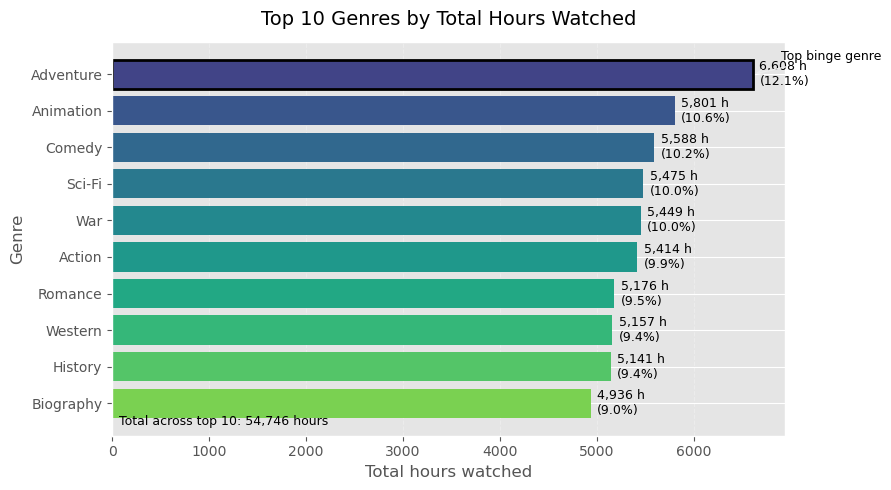

In [100]:
sql_top_genres = """
SELECT
    genre_primary,
    SUM(watch_duration_minutes) / 60.0 AS total_hours_watched
FROM vw_user_movie_sessions
GROUP BY genre_primary
ORDER BY total_hours_watched DESC
LIMIT 10;
"""

df_top_genres = con.execute(sql_top_genres).fetchdf()
display(df_top_genres)

import numpy as np
import matplotlib.pyplot as plt

# Sort so the biggest bar is at the top
df_sorted = df_top_genres.sort_values("total_hours_watched", ascending=True)

total_hours_all = df_sorted["total_hours_watched"].sum()
shares = df_sorted["total_hours_watched"] / total_hours_all * 100

fig, ax = plt.subplots(figsize=(9, 5))

# Use a colormap for a smooth gradient
cmap = plt.cm.get_cmap("viridis")
colors = cmap(np.linspace(0.8, 0.2, len(df_sorted)))

bars = ax.barh(
    df_sorted["genre_primary"],
    df_sorted["total_hours_watched"],
    color=colors
)

ax.set_title("Top 10 Genres by Total Hours Watched", fontsize=14, pad=12)
ax.set_xlabel("Total hours watched")
ax.set_ylabel("Genre")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Add labels: hours + share %
for bar, hours, pct in zip(bars,
                           df_sorted["total_hours_watched"],
                           shares):
    ax.text(
        hours + max(df_sorted["total_hours_watched"]) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{hours:,.0f} h\n({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
    )

# Highlight the top genre with a thicker border and annotation
top_bar = bars[-1]
top_hours = df_sorted.iloc[-1]["total_hours_watched"]
top_genre = df_sorted.iloc[-1]["genre_primary"]

top_bar.set_edgecolor("black")
top_bar.set_linewidth(2)

ax.annotate(
    "Top binge genre",
    xy=(top_hours, top_bar.get_y() + top_bar.get_height() / 2),
    xytext=(20, 10),
    textcoords="offset points",
    fontsize=9,
    arrowprops=dict(arrowstyle="->", linewidth=1),
)

# Small footer text: total hours across these genres
ax.text(
    0.01,
    0.02,
    f"Total across top 10: {total_hours_all:,.0f} hours",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="bottom",
)

plt.tight_layout()
plt.show()


### Insight: Engagement by age band

,age_band,sessions,avg_watch_minutes
0,35–44,38069,57.757911
1,25–34,25438,58.343356
2,45–54,14210,58.050120
3,18–24,10829,58.042165
4,Under 18,6656,57.800601
5,55+,4798,57.454481


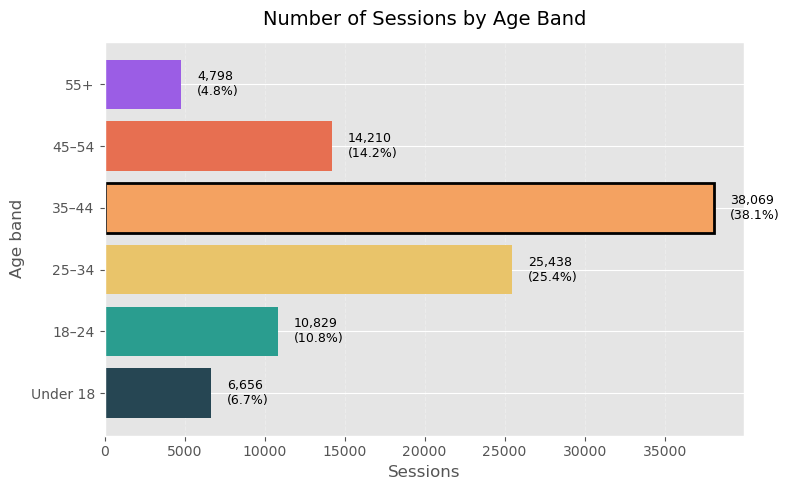

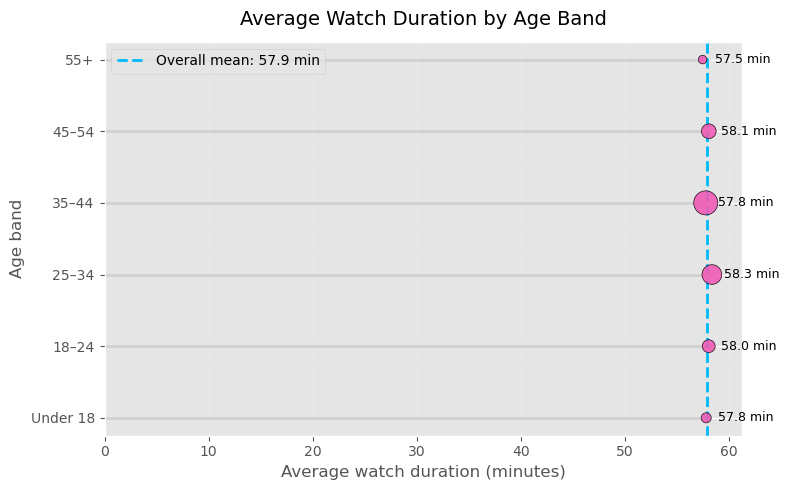

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sql_age_band_engagement = """
WITH sessions AS (
    SELECT
        CASE
            WHEN age < 18 THEN 'Under 18'
            WHEN age BETWEEN 18 AND 24 THEN '18–24'
            WHEN age BETWEEN 25 AND 34 THEN '25–34'
            WHEN age BETWEEN 35 AND 44 THEN '35–44'
            WHEN age BETWEEN 45 AND 54 THEN '45–54'
            ELSE '55+'
        END AS age_band,
        watch_duration_minutes
    FROM vw_user_movie_sessions
)
SELECT
    age_band,
    COUNT(*)                    AS sessions,
    AVG(watch_duration_minutes) AS avg_watch_minutes
FROM sessions
GROUP BY age_band
ORDER BY sessions DESC;
"""

df_age_band_engagement = con.execute(sql_age_band_engagement).fetchdf()
display(df_age_band_engagement)

# Ensure logical age order rather than “most sessions” order
age_order = ["Under 18", "18–24", "25–34", "35–44", "45–54", "55+"]
df = df_age_band_engagement.copy()
df["age_band"] = pd.Categorical(df["age_band"], categories=age_order, ordered=True)
df = df.sort_values("age_band")

# ==========================
# 1) Sessions by age band – horizontal, % labels, highlight
# ==========================
fig, ax = plt.subplots(figsize=(8, 5))

total_sessions = df["sessions"].sum()
sessions_pct = df["sessions"] / total_sessions * 100

# Custom palette
palette = [
    "#264653",  # deep teal
    "#2A9D8F",  # teal
    "#E9C46A",  # mustard
    "#F4A261",  # warm orange
    "#E76F51",  # coral
    "#9B5DE5",  # purple
]
colors = palette[:len(df)]

bars = ax.barh(df["age_band"], df["sessions"], color=colors)

ax.set_title("Number of Sessions by Age Band", fontsize=14, pad=12)
ax.set_xlabel("Sessions")
ax.set_ylabel("Age band")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Add count + percentage at end of each bar
for bar, sess, pct in zip(bars, df["sessions"], sessions_pct):
    ax.text(
        sess + total_sessions * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{sess:,}\n({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
    )

# Highlight the most active age band (by sessions)
max_idx = df["sessions"].idxmax()
highlight_bar = bars[list(df.index).index(max_idx)]
highlight_bar.set_edgecolor("black")
highlight_bar.set_linewidth(2)

plt.tight_layout()
plt.show()

# ==========================
# 2) Average watch duration – lollipop with bubble size
# ==========================
fig, ax = plt.subplots(figsize=(8, 5))

# Lollipop stems
ax.hlines(
    y=df["age_band"],
    xmin=0,
    xmax=df["avg_watch_minutes"],
    color="#d0d0d0",
    linewidth=2,
)

# Scale bubble sizes by sessions (for extra info)
size_scale = 300 / df["sessions"].max()
sizes = df["sessions"] * size_scale

# Lollipop heads
scatter = ax.scatter(
    df["avg_watch_minutes"],
    df["age_band"],
    s=sizes,
    color="#F15BB5",      # vibrant pink
    edgecolor="black",
    alpha=0.9,
    zorder=3,
)

# Overall mean line
mean_watch = df["avg_watch_minutes"].mean()
ax.axvline(
    mean_watch,
    color="#00BBF9",
    linestyle="--",
    linewidth=2,
    label=f"Overall mean: {mean_watch:.1f} min"
)

ax.set_title("Average Watch Duration by Age Band", fontsize=14, pad=12)
ax.set_xlabel("Average watch duration (minutes)")
ax.set_ylabel("Age band")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)
ax.set_xlim(left=0)

# Label each point with minutes
for x, y in zip(df["avg_watch_minutes"], df["age_band"]):
    ax.text(
        x + df["avg_watch_minutes"].max() * 0.02,
        y,
        f"{x:.1f} min",
        va="center",
        ha="left",
        fontsize=9,
    )

ax.legend()
plt.tight_layout()
plt.show()


### Insight: Genre-level quality (hours watched + average rating)

,genre_primary,total_hours_watched,avg_review_rating,review_count
0,Adventure,6608.008333,3.703704,999
1,Animation,5801.470000,3.633078,913
2,Comedy,5588.038333,3.595745,846
3,Sci-Fi,5475.298333,3.646081,842
4,War,5448.538333,3.675355,844
5,Action,5414.178333,3.612943,819
6,Romance,5175.608333,3.719298,741
7,Western,5157.041667,3.623116,796
8,History,5140.970000,3.663671,779
9,Biography,4936.393333,3.685112,759


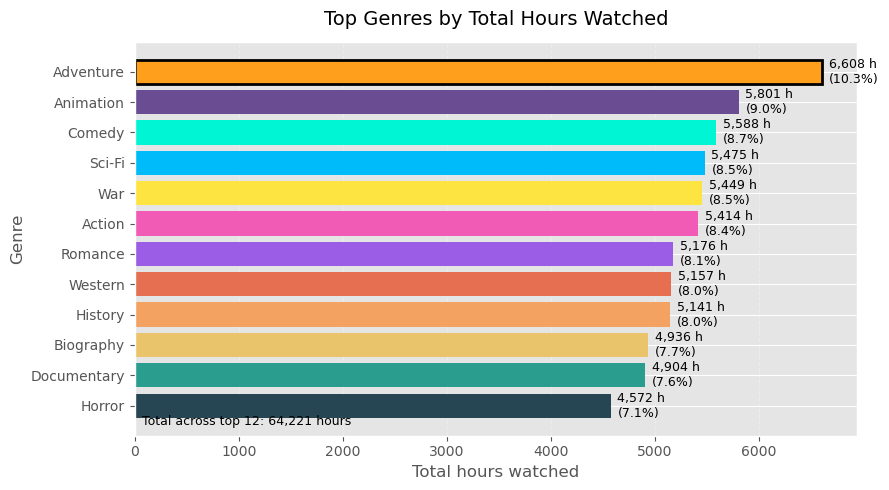

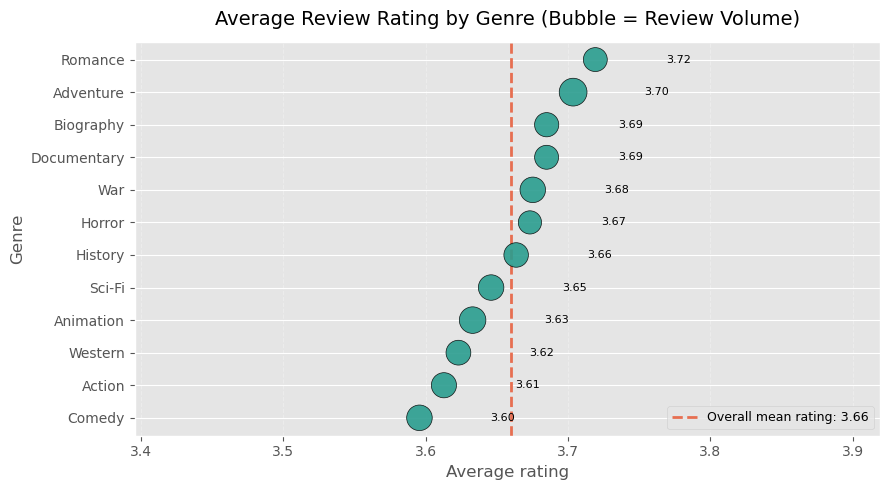

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sql_genre_quality = """
WITH session_genre AS (
    SELECT
        w.movie_id,
        m.genre_primary,
        SUM(w.watch_duration_minutes) / 60.0 AS hours_watched
    FROM watch_history_clean w
    JOIN movies_clean m USING (movie_id)
    GROUP BY w.movie_id, m.genre_primary
),
genre_ratings AS (
    SELECT
        m.genre_primary,
        AVG(r.rating) AS avg_review_rating,
        COUNT(*)      AS review_count
    FROM reviews_clean r
    JOIN movies_clean m USING (movie_id)
    GROUP BY m.genre_primary
)
SELECT
    g.genre_primary,
    SUM(g.hours_watched)          AS total_hours_watched,
    r.avg_review_rating,
    r.review_count
FROM session_genre g
LEFT JOIN genre_ratings r USING (genre_primary)
GROUP BY g.genre_primary, r.avg_review_rating, r.review_count
ORDER BY total_hours_watched DESC;
"""

df_genre_quality = con.execute(sql_genre_quality).fetchdf()
display(df_genre_quality)

# ============
# Prep data
# ============
df = df_genre_quality.copy()

# Optional: focus on top 12 by hours watched to keep charts readable
top_n = 12
df_top = df.sort_values("total_hours_watched", ascending=False).head(top_n)

# -------------------------------
# 1) Total hours watched by genre
#    → horizontal bars + labels
# -------------------------------
df_hours = df_top.sort_values("total_hours_watched", ascending=True)

total_hours_all = df_hours["total_hours_watched"].sum()
shares = df_hours["total_hours_watched"] / total_hours_all * 100

fig, ax = plt.subplots(figsize=(9, 5))

# Custom color palette (smooth but not default)
palette = [
    "#264653",  # deep teal
    "#2A9D8F",  # teal
    "#E9C46A",  # mustard
    "#F4A261",  # warm orange
    "#E76F51",  # coral
    "#9B5DE5",  # purple
    "#F15BB5",  # pink
    "#FEE440",  # bright yellow
    "#00BBF9",  # bright blue
    "#00F5D4",  # aqua
    "#6A4C93",  # violet
    "#ff9f1c",  # amber
]
colors = palette[:len(df_hours)]

bars = ax.barh(
    df_hours["genre_primary"],
    df_hours["total_hours_watched"],
    color=colors
)

ax.set_title("Top Genres by Total Hours Watched", fontsize=14, pad=12)
ax.set_xlabel("Total hours watched")
ax.set_ylabel("Genre")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

max_hours = df_hours["total_hours_watched"].max()

# Label each bar with hours + percentage share
for bar, hours, pct in zip(
    bars,
    df_hours["total_hours_watched"],
    shares
):
    ax.text(
        hours + max_hours * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{hours:,.0f} h\n({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
    )

# Highlight the very top genre visually
top_bar = bars[-1]
top_bar.set_edgecolor("black")
top_bar.set_linewidth(2)

ax.text(
    0.01,
    0.02,
    f"Total across top {len(df_hours)}: {total_hours_all:,.0f} hours",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="bottom",
)

plt.tight_layout()
plt.show()

# ------------------------------------------
# 2) Average review rating by genre (smoothed)
#    → bubble chart (rating vs genre)
#       - x: avg rating
#       - y: genre
#       - bubble size: review_count
#       - vertical line: overall mean rating
# ------------------------------------------
df_rating = df_top.dropna(subset=["avg_review_rating"]).copy()

# Sort genres by rating so the plot feels "smooth"
df_rating = df_rating.sort_values("avg_review_rating", ascending=True)

fig, ax = plt.subplots(figsize=(9, 5))

# Bubble sizes proportional to review count
if df_rating["review_count"].max() > 0:
    size_scale = 400 / df_rating["review_count"].max()
else:
    size_scale = 1.0
sizes = df_rating["review_count"] * size_scale

# Use a softer, single color with outline
scatter = ax.scatter(
    df_rating["avg_review_rating"],
    df_rating["genre_primary"],
    s=sizes,
    color="#2A9D8F",       # teal
    edgecolor="black",
    alpha=0.9,
    zorder=3
)

mean_rating = df_rating["avg_review_rating"].mean()

# Mean line for smooth reference
ax.axvline(
    mean_rating,
    color="#E76F51",
    linestyle="--",
    linewidth=2,
    label=f"Overall mean rating: {mean_rating:.2f}"
)

ax.set_title("Average Review Rating by Genre (Bubble = Review Volume)", fontsize=14, pad=12)
ax.set_xlabel("Average rating")
ax.set_ylabel("Genre")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Make x-axis a bit padded
xmin = max(0, df_rating["avg_review_rating"].min() - 0.2)
xmax = min(10, df_rating["avg_review_rating"].max() + 0.2)
ax.set_xlim(xmin, xmax)

# Label each bubble with rating
for x, y in zip(df_rating["avg_review_rating"], df_rating["genre_primary"]):
    ax.text(
        x + 0.05,
        y,
        f"{x:.2f}",
        va="center",
        ha="left",
        fontsize=8,
    )

ax.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


### Insight: Recommendation CTR by type

,recommendation_type,impressions,ctr
0,new_releases,9950,0.155678
1,trending,9949,0.151473
2,similar_users,9942,0.150976
3,personalized,10170,0.149066
4,genre_based,9989,0.147863


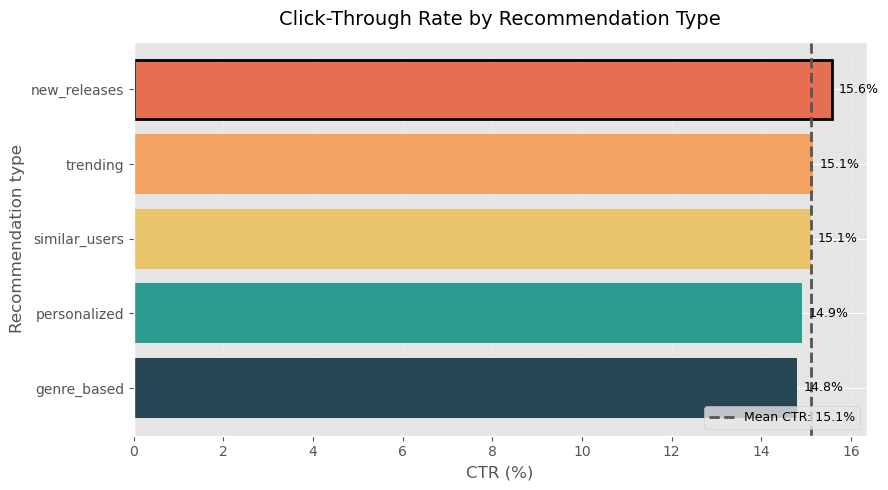

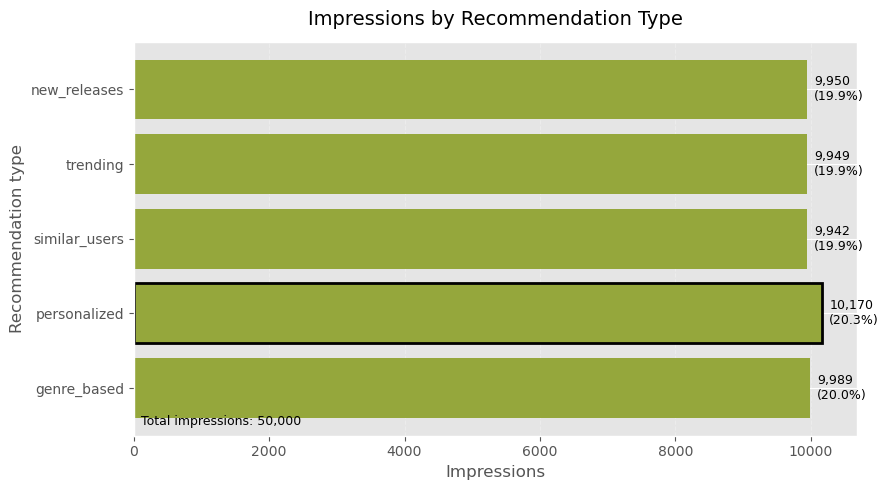

In [105]:
sql_ctr_by_rec_type = """
SELECT
    recommendation_type,
    COUNT(*) AS impressions,
    AVG(CASE WHEN was_clicked THEN 1.0 ELSE 0.0 END) AS ctr
FROM recommendation_logs_clean
GROUP BY recommendation_type
ORDER BY ctr DESC;
"""

df_ctr_by_rec_type = con.execute(sql_ctr_by_rec_type).fetchdf()
display(df_ctr_by_rec_type)

import matplotlib.pyplot as plt
import numpy as np

df_ctr = df_ctr_by_rec_type.copy()

# Convert CTR to percentage
df_ctr["ctr_pct"] = df_ctr["ctr"] * 100

# Sort by CTR for nicer visual
df_ctr = df_ctr.sort_values("ctr_pct", ascending=True)

# ==========================
# 1) CTR by recommendation type (horizontal, %)
# ==========================
fig, ax = plt.subplots(figsize=(9, 5))

# Custom palette (no default blue)
palette = [
    "#264653",  # deep teal
    "#2A9D8F",  # teal
    "#E9C46A",  # mustard
    "#F4A261",  # warm orange
    "#E76F51",  # coral
    "#9B5DE5",  # purple
    "#F15BB5",  # pink
    "#00BBF9",  # bright blue
    "#00F5D4",  # aqua
]
colors = palette[:len(df_ctr)]

bars = ax.barh(
    df_ctr["recommendation_type"],
    df_ctr["ctr_pct"],
    color=colors
)

ax.set_title("Click-Through Rate by Recommendation Type", fontsize=14, pad=12)
ax.set_xlabel("CTR (%)")
ax.set_ylabel("Recommendation type")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Mean CTR line
mean_ctr_pct = df_ctr["ctr_pct"].mean()
ax.axvline(
    mean_ctr_pct,
    color="#555555",
    linestyle="--",
    linewidth=2,
    label=f"Mean CTR: {mean_ctr_pct:.1f}%"
)

# Label each bar with CTR%
for bar, pct in zip(bars, df_ctr["ctr_pct"]):
    ax.text(
        pct + max(df_ctr["ctr_pct"]) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.1f}%",
        va="center",
        ha="left",
        fontsize=9
    )

# Highlight best performer
best_bar = bars[-1]
best_bar.set_edgecolor("black")
best_bar.set_linewidth(2)

ax.legend(loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()

# ==========================
# 2) Impressions by recommendation type (aligned order)
# ==========================
df_imp = df_ctr[["recommendation_type", "impressions"]].copy()
total_impressions = df_imp["impressions"].sum()
df_imp["share_pct"] = df_imp["impressions"] / total_impressions * 100

fig, ax = plt.subplots(figsize=(9, 5))

bars2 = ax.barh(
    df_imp["recommendation_type"],
    df_imp["impressions"],
    color="#95A73C"  # consistent teal
)

ax.set_title("Impressions by Recommendation Type", fontsize=14, pad=12)
ax.set_xlabel("Impressions")
ax.set_ylabel("Recommendation type")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

max_imp = df_imp["impressions"].max()

# Label each bar with count + share%
for bar, (_, row) in zip(bars2, df_imp.iterrows()):
    val = row["impressions"]
    share = row["share_pct"]
    ax.text(
        val + max_imp * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}\n({share:.1f}%)",
        va="center",
        ha="left",
        fontsize=9
    )

# Highlight the highest-volume rec type
top_bar2 = bars2[np.argmax(df_imp["impressions"].values)]
top_bar2.set_edgecolor("black")
top_bar2.set_linewidth(2)

# Footer summary
ax.text(
    0.01,
    0.02,
    f"Total impressions: {total_impressions:,}",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="bottom"
)

plt.tight_layout()
plt.show()


### Insight: “Click → Watch” conversion for recommendations

,total_clicked_recs,recs_with_watch,watched_after_click_rate
0,7550,44,0.005828


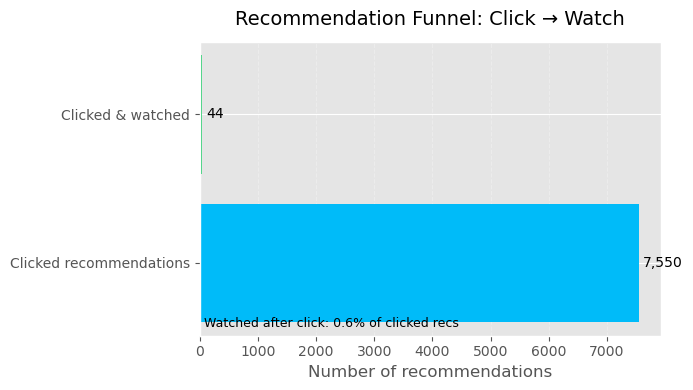

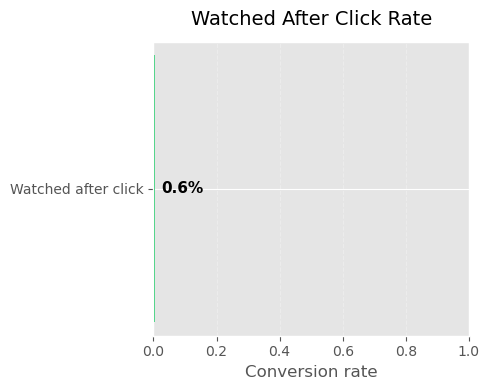

In [106]:
sql_click_to_watch = """
WITH rec_clicks AS (
    SELECT
        recommendation_id,
        user_id,
        movie_id,
        recommendation_date
    FROM recommendation_logs_clean
    WHERE was_clicked = TRUE
),
subsequent_watch AS (
    SELECT DISTINCT
        r.recommendation_id
    FROM rec_clicks r
    JOIN watch_history_clean w
      ON r.user_id = w.user_id
     AND r.movie_id = w.movie_id
     AND w.watch_date >= r.recommendation_date
)
SELECT
    COUNT(*) AS total_clicked_recs,
    (SELECT COUNT(*) FROM subsequent_watch) AS recs_with_watch,
    (SELECT COUNT(*) FROM subsequent_watch) * 1.0 
        / COUNT(*) AS watched_after_click_rate
FROM rec_clicks;
"""

df_click_to_watch = con.execute(sql_click_to_watch).fetchdf()
display(df_click_to_watch)

import matplotlib.pyplot as plt

total_clicked = int(df_click_to_watch["total_clicked_recs"].iloc[0])
recs_with_watch = int(df_click_to_watch["recs_with_watch"].iloc[0])
watch_rate = float(df_click_to_watch["watched_after_click_rate"].iloc[0])
watch_rate_pct = watch_rate * 100

# ==========================
# 1) Funnel-style counts chart
# ==========================
labels = ["Clicked recommendations", "Clicked & watched"]
values = [total_clicked, recs_with_watch]

fig, ax = plt.subplots(figsize=(7, 4))

colors = ["#00BBF9", "#2ECC71"]  # blue -> green funnel steps

bars = ax.barh(labels, values, color=colors)

ax.set_title("Recommendation Funnel: Click → Watch", fontsize=14, pad=12)
ax.set_xlabel("Number of recommendations")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Add count + drop-off percentage on each bar
for bar, val, label in zip(bars, values, labels):
    ax.text(
        val + max(values) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=10,
    )

# Extra annotation for overall conversion
ax.text(
    0.01,
    0.02,
    f"Watched after click: {watch_rate_pct:.1f}% of clicked recs",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="bottom",
)

plt.tight_layout()
plt.show()

# ==========================
# 2) Conversion rate bar (single metric)
# ==========================
fig, ax = plt.subplots(figsize=(5, 4))

ax.barh(["Watched after click"], [watch_rate], color="#2ECC71")

ax.set_xlim(0, 1)
ax.set_xlabel("Conversion rate")
ax.set_title("Watched After Click Rate", fontsize=14, pad=12)
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

# Show percentage inside / next to bar
ax.text(
    watch_rate + 0.02 if watch_rate < 0.8 else watch_rate - 0.02,
    0,  # only one bar
    f"{watch_rate_pct:.1f}%",
    va="center",
    ha="right" if watch_rate >= 0.8 else "left",
    fontsize=11,
    fontweight="bold",
)

plt.tight_layout()
plt.show()


### Insight: Search vs non-search users

,segment,users
0,Searched at least once,9186
1,Watched but never searched,814


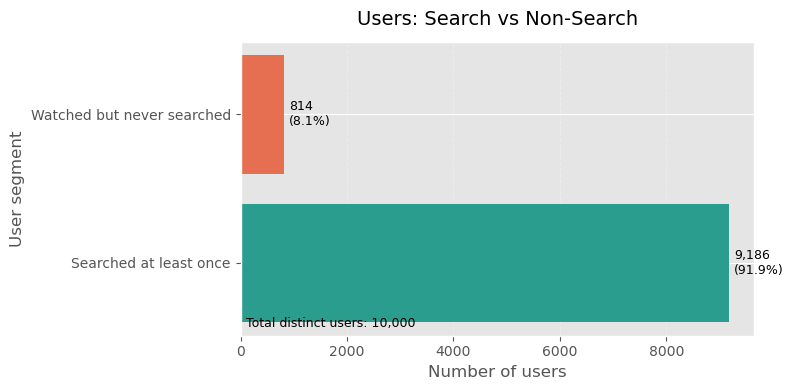

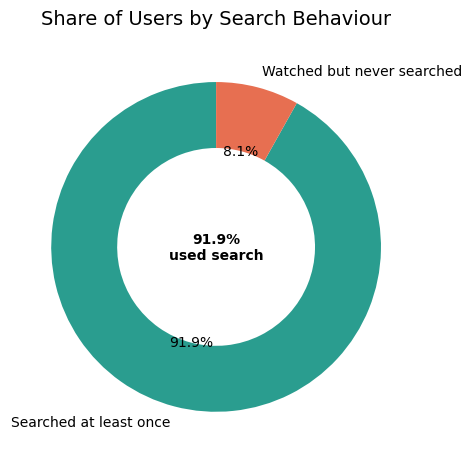

In [107]:
sql_search_vs_nosearch = """
WITH search_users AS (
    SELECT DISTINCT user_id
    FROM search_logs_clean
),
watch_users AS (
    SELECT DISTINCT user_id
    FROM watch_history_clean
)
SELECT
    'Searched at least once' AS segment,
    COUNT(*)                 AS users
FROM search_users
UNION ALL
SELECT
    'Watched but never searched' AS segment,
    COUNT(*) AS users
FROM watch_users
WHERE user_id NOT IN (SELECT user_id FROM search_users);
"""

df_search_vs_nosearch = con.execute(sql_search_vs_nosearch).fetchdf()
display(df_search_vs_nosearch)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure consistent order
order = ["Searched at least once", "Watched but never searched"]
df_seg = df_search_vs_nosearch.copy()
df_seg["segment"] = pd.Categorical(df_seg["segment"], categories=order, ordered=True)
df_seg = df_seg.sort_values("segment")

total_users = df_seg["users"].sum()
df_seg["pct"] = df_seg["users"] / total_users * 100

# ==========================
# 1) Horizontal bar with counts + %
# ==========================
fig, ax = plt.subplots(figsize=(8, 4))

colors = ["#2A9D8F", "#E76F51"]  # teal vs coral

bars = ax.barh(df_seg["segment"], df_seg["users"], color=colors)

ax.set_title("Users: Search vs Non-Search", fontsize=14, pad=12)
ax.set_xlabel("Number of users")
ax.set_ylabel("User segment")
ax.grid(True, axis="x", linestyle="--", alpha=0.3)

max_users = df_seg["users"].max()

# Add counts + percentages at end of bars
for bar, (_, row) in zip(bars, df_seg.iterrows()):
    val = row["users"]
    pct = row["pct"]
    ax.text(
        val + max_users * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}\n({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9
    )

# Small footer summary
ax.text(
    0.01,
    0.02,
    f"Total distinct users: {total_users:,}",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="bottom"
)

plt.tight_layout()
plt.show()

# ==========================
# 2) Donut chart for share of segments
# ==========================
fig, ax = plt.subplots(figsize=(5, 5))

wedges, texts, autotexts = ax.pie(
    df_seg["users"],
    labels=df_seg["segment"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)  # donut effect
)

ax.set_title("Share of Users by Search Behaviour", fontsize=14, pad=12)

# Center text: % who searched at least once
search_row = df_seg[df_seg["segment"] == "Searched at least once"].iloc[0]
ax.text(
    0, 0,
    f"{search_row['pct']:.1f}%\nused search",
    ha="center",
    va="center",
    fontsize=10,
    fontweight="bold"
)

plt.tight_layout()
plt.show()
